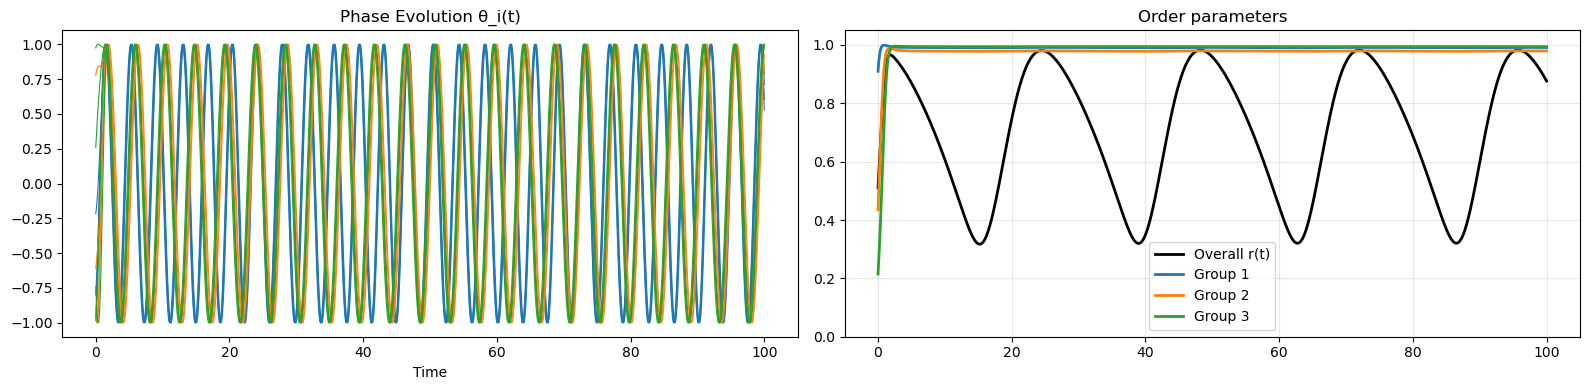

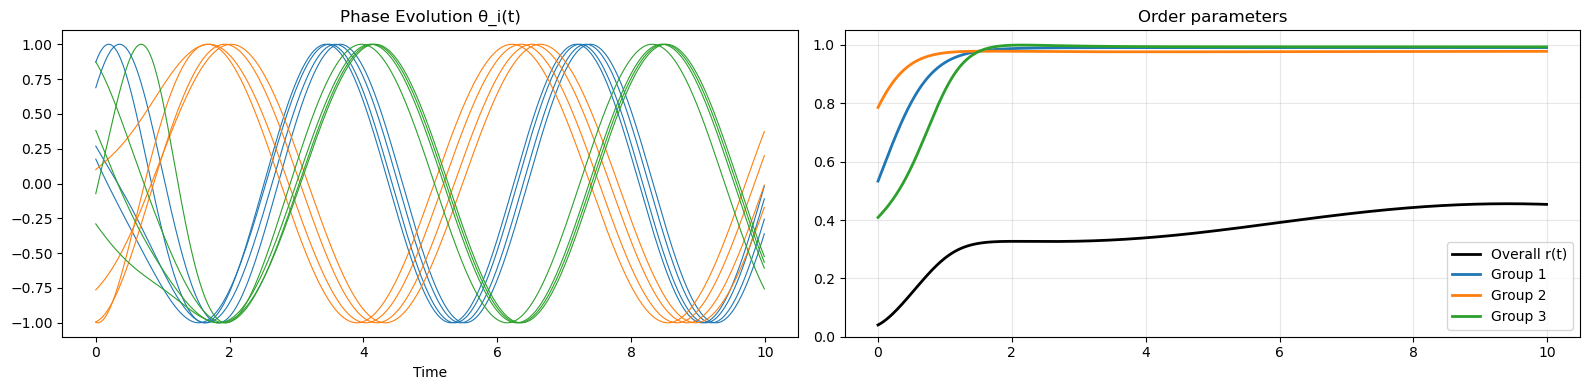

In [1]:
from deepkoop_func import Lusch
from deepkoop_func import koopman_loss,prediction_loss
from deepkoop_func import prepare_dataloader, create_sequences
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto


N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01
x_train, theta_hist, t_train, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_test, theta_hist, t_test, _ = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=10,
    random_seed1=0, random_seed2=5,
    dt=dt
)



In [1]:
import xarray as xr
from deepkoop_func import Lusch
from deepkoop_func import koopman_loss, prediction_loss, get_device
from deepkoop_func import prepare_dataloader, create_sequences
from tools import get_positive_contributions, compute_entropy
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from data_func import plot_clustered_kuramoto
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
# 将 .dims 改为 .sizes
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


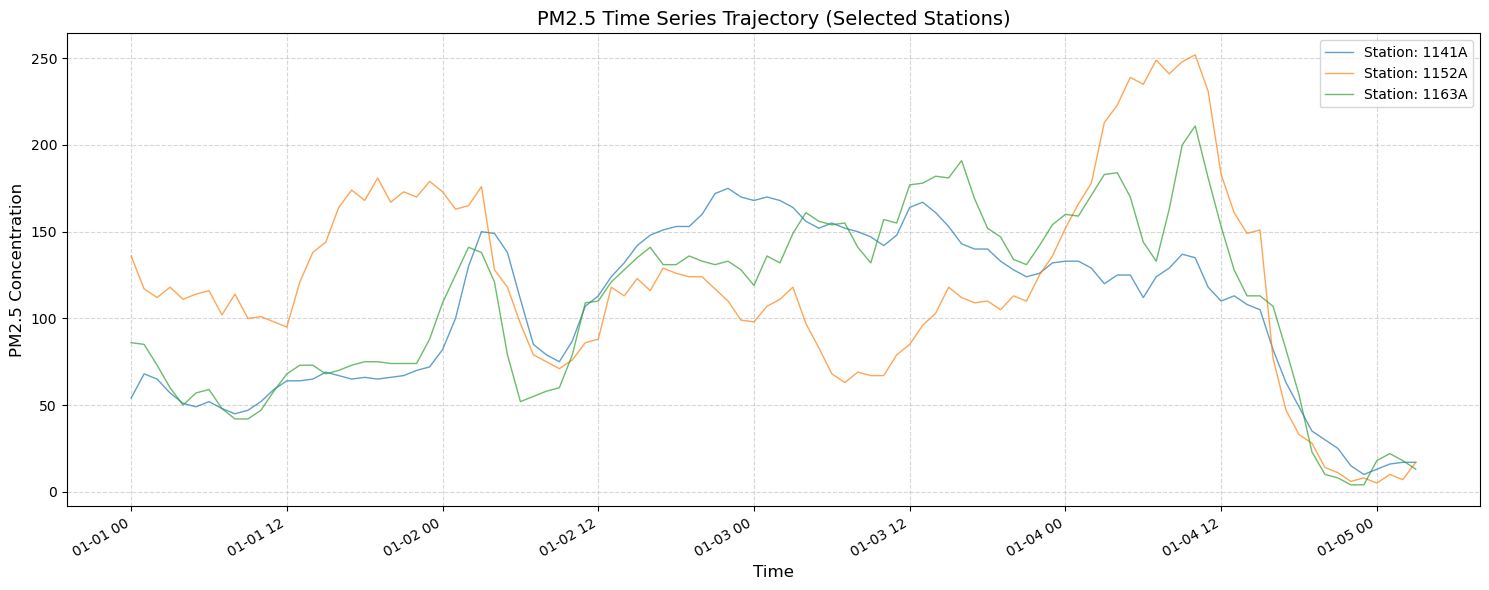

In [2]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data = pm25.isel(station=idx).values
    
    plt.plot(times[:100], station_data[:100], label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('PM2.5 Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [3]:
x_train = pm25.values[:60000, :]
x_test = pm25.values[60000:, :]
x_train.shape

(60000, 127)

  0%|          | 0/188 [00:00<?, ?it/s]/Users/yangmingzhe/Desktop/code/github/koopCE/notebooks/deepkoop_func.py:88: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  _, S_tensor, _ = torch.linalg.svd(K_tensor, full_matrices=False)
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: aten::linalg_svd: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeIm


 ==========  EPOCH 0  ==========

Prediction Loss: 538.6055
TRAIN LOSS:  6835.729950600482
TEST LOSS:  1932.4687551944814
pred LOSS:  777.093118870512
reconstruction LOSS:  181.3389366636885
lin LOSS:  15.604627649834816
inf LOSS:  214.3851743657538
ce LOSS:  -126.21739196777344


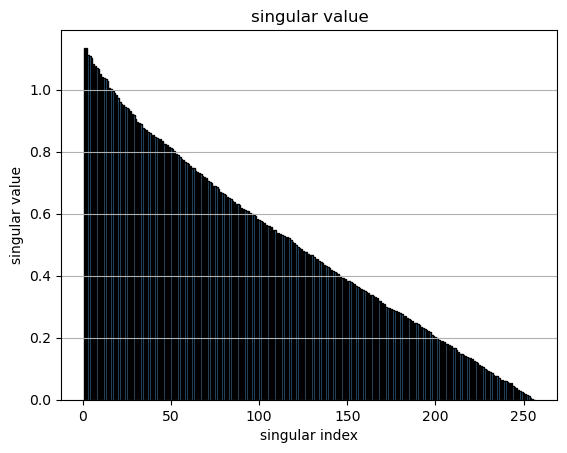

100%|██████████| 47/47 [00:02<00:00, 23.48it/s]



 ==========  EPOCH 10  ==========

Prediction Loss: 399.7146
TRAIN LOSS:  1255.9090381378824
TEST LOSS:  1242.5660893866357
pred LOSS:  566.4122496259973
reconstruction LOSS:  53.01169082966257
lin LOSS:  3.7182147756535957
inf LOSS:  184.56453785997755
ce LOSS:  -127.39879608154297


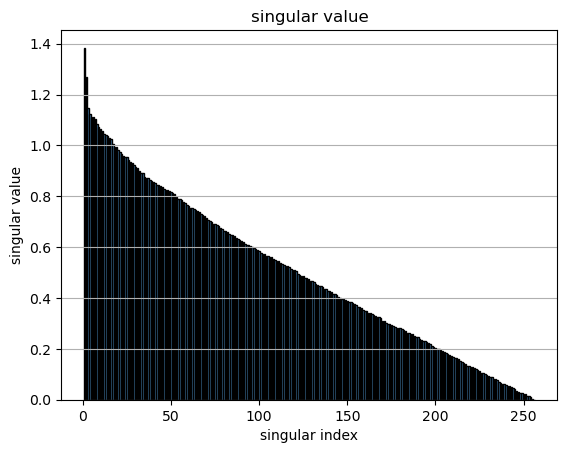

100%|██████████| 47/47 [00:01<00:00, 23.58it/s]



 ==========  EPOCH 20  ==========

Prediction Loss: 402.3900
TRAIN LOSS:  1146.18885251309
TEST LOSS:  1183.6912582072805
pred LOSS:  546.9882572255236
reconstruction LOSS:  43.4465343394178
lin LOSS:  2.8216811849715864
inf LOSS:  184.71233449083692
ce LOSS:  -127.8075942993164


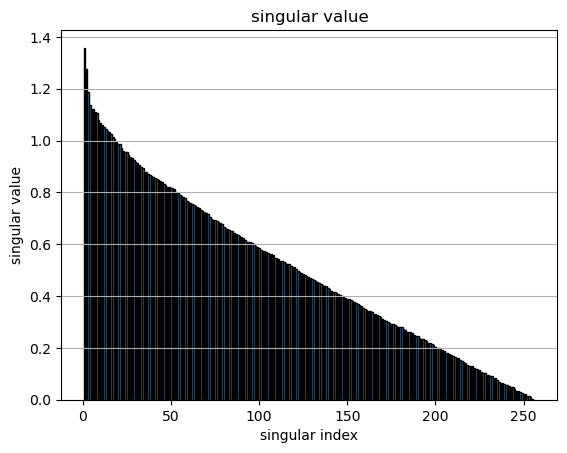

100%|██████████| 47/47 [00:02<00:00, 23.44it/s]



 ==========  EPOCH 30  ==========

Prediction Loss: 401.9138
TRAIN LOSS:  1087.913931664
TEST LOSS:  1123.718716235871
pred LOSS:  519.4406822691573
reconstruction LOSS:  40.99764641295088
lin LOSS:  2.842061235549602
inf LOSS:  176.996950190118
ce LOSS:  -128.31539916992188


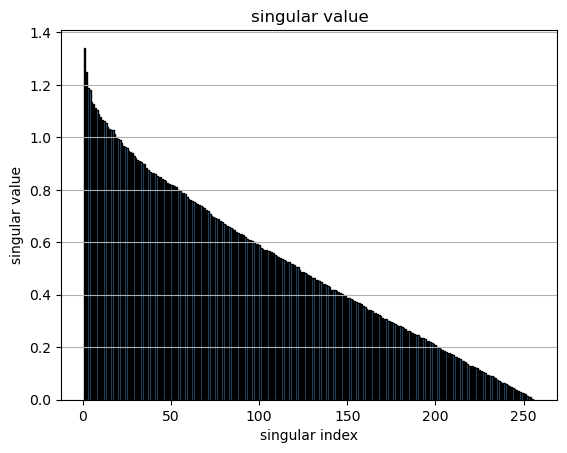

100%|██████████| 47/47 [00:02<00:00, 23.30it/s]



 ==========  EPOCH 40  ==========

Prediction Loss: 415.3746
TRAIN LOSS:  1009.458931456221
TEST LOSS:  1066.6615146068816
pred LOSS:  491.3284821205951
reconstruction LOSS:  40.49927204213244
lin LOSS:  3.006004323350622
inf LOSS:  175.5228368880901
ce LOSS:  -128.8860626220703


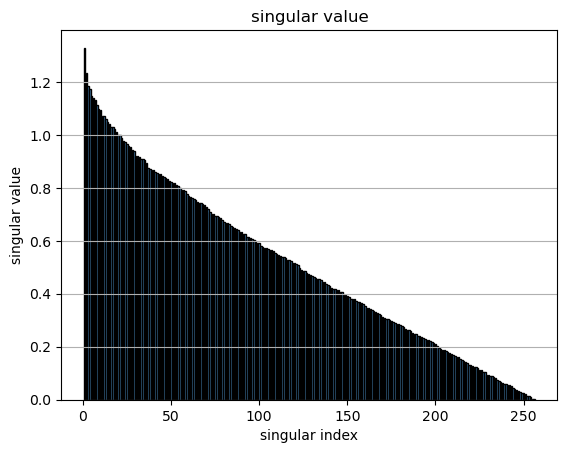

100%|██████████| 47/47 [00:02<00:00, 23.49it/s]


In [4]:
koopman_dim = 256
# encoder dim
hidden_dim = 512
input_dim = 127

epochs = 50
lr = 1e-3
Sp = 72; horizon = 72; T = max(horizon,Sp)
batch_size = 256
alpha1 = 2
alpha2 = 1e-8
alpha_CE = 0
device = get_device(force_cpu=False)

model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

train_loader, val_loader = prepare_dataloader(x_train, T, batch_size=batch_size)
x_train_dims = create_sequences(x_train,T+1)
x_test_dims = create_sequences(x_test,T+1)
X_train_recon = x_train_dims[:,:-T,:]; X_test_recon = x_test_dims[:,:-T,:]
X_forecast_train = x_train_dims[:,-T:,:]; X_forecast_test = x_test_dims[:,-T:,:]

# model.mu = train_loader.dataset.mu.to(device)
# model.std = train_loader.dataset.std.to(device)

for epoch in range(0, epochs):
    train_epoch_loss = []
    test_epoch_loss = []
    pred_epoch_loss = []
    reconstruction_epoch_loss = []
    lin_epoch_loss = []
    inf_epoch_loss = []
    ce_epoch_loss = []

    model.train()
    for (x,) in tqdm(train_loader):
        optimizer.zero_grad()
        loss_train, _, _, _, _, _ = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
        loss_train.backward()
        optimizer.step()
        train_epoch_loss.append(loss_train.item())

    with torch.no_grad():
        model.eval()
        for (x,) in tqdm(val_loader):
            loss_test, pred_loss, reconstruction_loss, lin_loss, inf_loss, ce_loss = koopman_loss(x.to(device=device), model, Sp=Sp, T=T, alpha1=alpha1, alpha2=alpha2, alpha_CE=alpha_CE)
            test_epoch_loss.append(loss_test.cpu().item())
            pred_epoch_loss.append(pred_loss.cpu().item())
            reconstruction_epoch_loss.append(reconstruction_loss.cpu().item())
            lin_epoch_loss.append(lin_loss.cpu().item())
            inf_epoch_loss.append(inf_loss.cpu().item())
            ce_epoch_loss.append(ce_loss.cpu().item())

        forecast_loss = prediction_loss(X_test_recon[:,[-1],:].to(device=device), X_forecast_test.to(device=device),model)

    if epoch % 10 == 0:
        print("\n","="*10,f" EPOCH {epoch} ","="*10)
        print("\nPrediction Loss: {:.4f}".format(forecast_loss))
        # print("Reconstruction Loss: {:.4f}".format(reconstruction_loss))
        print("TRAIN LOSS: ",np.sum(train_epoch_loss)/len(train_epoch_loss))
        print("TEST LOSS: ",np.sum(test_epoch_loss)/len(test_epoch_loss))
        print("pred LOSS: ",np.sum(pred_epoch_loss)/len(pred_epoch_loss))
        print("reconstruction LOSS: ",np.sum(reconstruction_epoch_loss)/len(reconstruction_epoch_loss))
        print("lin LOSS: ",np.sum(lin_epoch_loss)/len(lin_epoch_loss))
        print("inf LOSS: ",np.sum(inf_epoch_loss)/len(inf_epoch_loss))
        print("ce LOSS: ",np.sum(ce_epoch_loss)/len(ce_epoch_loss))
        K = model.koopman.linear_evolution.weight.cpu().data.numpy()
        U,S,V = np.linalg.svd(K)
        plt.figure()
        plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
        plt.grid(True, axis='y')         
        plt.xlabel('singular index')
        plt.ylabel('singular value')
        plt.title('singular value')
        plt.show()

In [5]:
save_path = "model_save/air127_ce0.pth"
print(f"正在保存模型参数到 {save_path} ...")

# 核心代码：只保存 state_dict (参数字典)
torch.save(model.state_dict(), save_path)
print("保存成功！")

正在保存模型参数到 model_save/air127_ce0.pth ...
保存成功！


cpu: 51min; mps: 17min

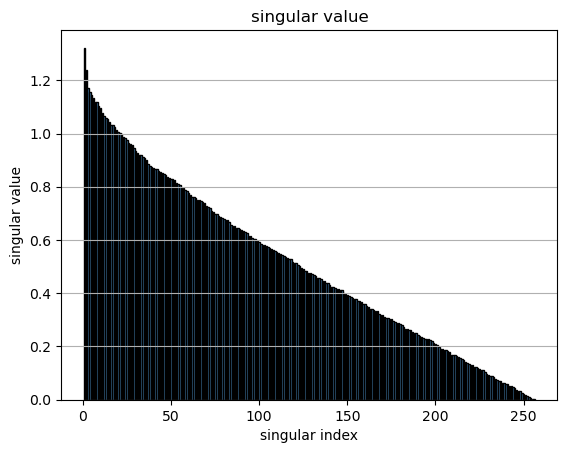

In [6]:
K = model.koopman.linear_evolution.weight.cpu().data.numpy()
U,S,V = np.linalg.svd(K)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

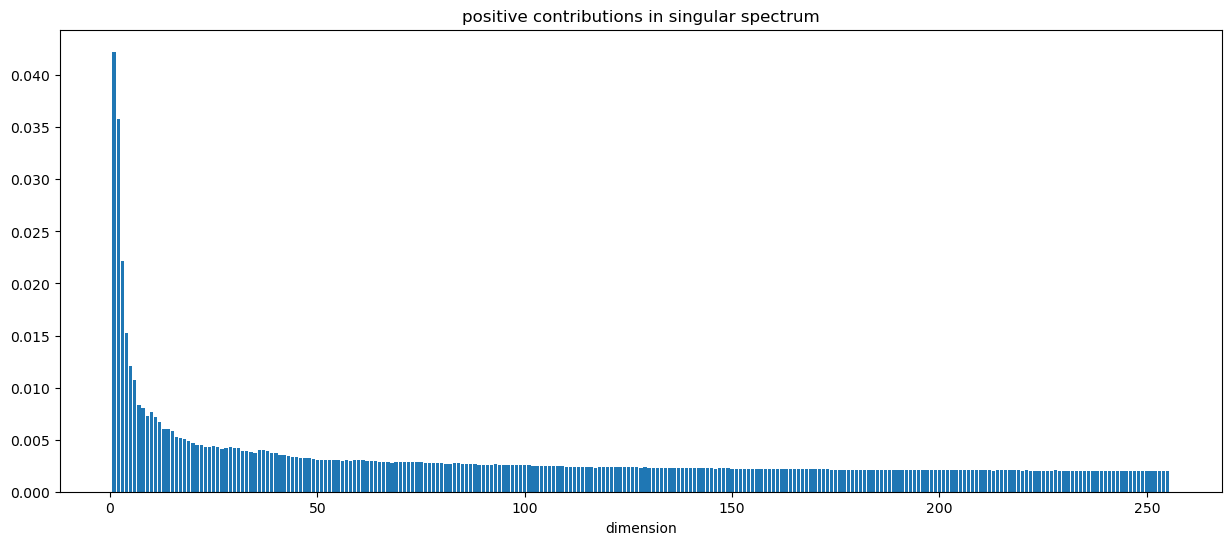

In [7]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [8]:
# 计算EC
print(compute_entropy(diff))

7.598192678950483


In [23]:
import numpy as np
import torch
from pysr import PySRRegressor

def eq_coarse_grain(model, dataloader, coarse_grain_coff, num_samples=2000):
    model.eval()
    device = next(model.parameters()).device
    
    X_input_list = []
    macro_list = []
    
    count = 0
    with torch.no_grad():
        for batch_x in dataloader:
            x = batch_x[0][:, 0, :].to(device) # [B, T, D]

            # 1. 获取 Latent State (Encoder)
            g = model.encoder(x)
            macro = g.cpu().numpy() @ coarse_grain_coff
            
            X_input_list.append(x.cpu().numpy())
            macro_list.append(macro)
            
            count += x.shape[0]
            if count >= num_samples:
                break
                
    X_data = np.concatenate(X_input_list, axis=0)[:num_samples]
    macro_data = np.concatenate(macro_list, axis=0)[:num_samples]
    
    return X_data, macro_data

rank = 2
coarse_grain_coff = U[:,:rank]
X_np, macro_data = eq_coarse_grain(model, train_loader, coarse_grain_coff, num_samples=1000)
print(f"Sampled shapes: micro={X_np.shape}, macro={macro_data.shape}")

Sampled shapes: micro=(1000, 127), macro=(1000, 2)


In [26]:
default_pysr_params = dict(
    populations=100,
    model_selection="accuracy", #best, accuracy
    niterations=40, # 迭代次数越多越精确，但越慢
    # 选择适合动力系统的算子
    binary_operators=["+", "-", "*", "/", '^'],
    unary_operators=[
        "cos", "sin", "square", "sqrt"
    ],
    maxsize=25, # 限制公式复杂度
    temp_equation_file=False, 
    delete_tempfiles=True,
    verbosity=0,
    denoise=False,
    procs=4, # 并行核心数
)

encoder_eqs = []
latent_dim = macro_data.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, macro_data[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"Y_{i} = {eq}")

# decoder_eqs = []
# input_dim = X_np.shape[1]

# for i in range(input_dim):
#     print(f"--- Fitting Observable Dimension x_{i} ---")
#     model_sr = PySRRegressor(**default_pysr_params)
#     model_sr.fit(macro_data, X_np[:, i])
    
#     eq = model_sr.sympy()
#     decoder_eqs.append(eq)
#     print(f"x_{i} = {eq}")


--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


Y_0 = -4.037718*x17**0.8736503/(x12 + x37**0.5229874) + sqrt(x31) - 0.09111119*x37 + 0.040783904*x47 - 4.287602
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


Y_1 = ((x47*x76*0.2317218)**(0.4174533 - 1/x105**0.7471479) - 1*6.0973983 - 0.8928985*1.0489088/x11*0.14741158)*0.82257134


In [27]:
print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"Y[{i}] = {eq}")


# print("\n[Decoder Functions]:")
# for i, eq in enumerate(decoder_eqs):
#     print(f"x[{i}] = {eq}")


[Encoder Functions]:
Y[0] = -4.037718*x17**0.8736503/(x12 + x37**0.5229874) + sqrt(x31) - 0.09111119*x37 + 0.040783904*x47 - 4.287602
Y[1] = ((x47*x76*0.2317218)**(0.4174533 - 1/x105**0.7471479) - 1*6.0973983 - 0.8928985*1.0489088/x11*0.14741158)*0.82257134
